In [1]:
# First, let's import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the results
basic_results = pd.read_csv('test_results/basic_results.txt', skiprows=1)
flash_results = pd.read_csv('test_results/flash_results.txt', skiprows=1)

# Create a function to format configuration strings
def format_config(row):
    return f"{row['batch_size']}/{row['num_heads']}/{row['seq_len']}/{row['head_dim']}"

# Add configuration column to both dataframes
basic_results['config'] = basic_results.apply(format_config, axis=1)
flash_results['config'] = flash_results.apply(format_config, axis=1)

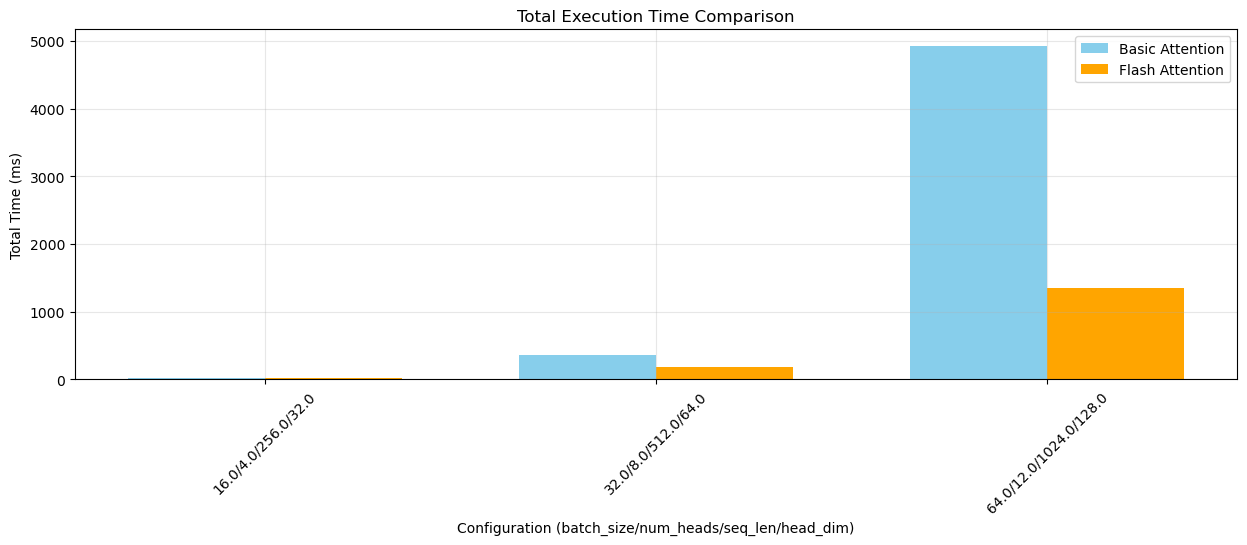

In [3]:
# Create comparison plots
plt.figure(figsize=(15, 10))

# Plot 1: Total Execution Time Comparison
plt.subplot(2, 1, 1)
bar_width = 0.35
configs = basic_results['config'].values
x = range(len(configs))

plt.bar([i - bar_width/2 for i in x], basic_results['total_time'], 
        bar_width, label='Basic Attention', color='skyblue')
plt.bar([i + bar_width/2 for i in x], flash_results['total_time'], 
        bar_width, label='Flash Attention', color='orange')

plt.xlabel('Configuration (batch_size/num_heads/seq_len/head_dim)')
plt.ylabel('Total Time (ms)')
plt.title('Total Execution Time Comparison')
plt.xticks(x, configs, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

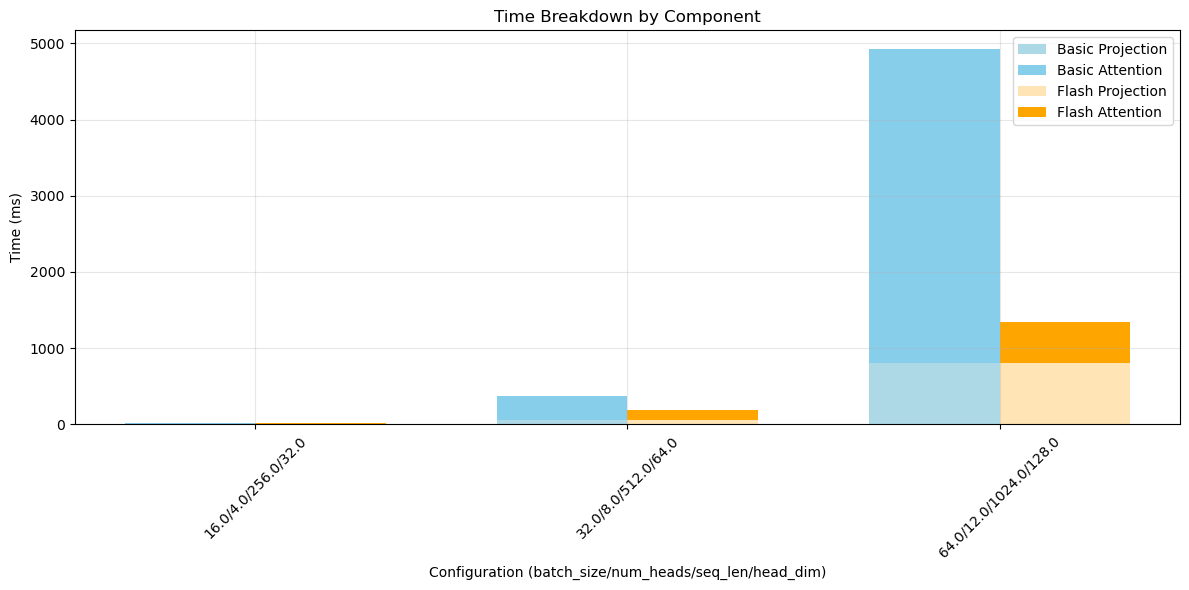


Speedup Analysis:
         Configuration  Basic Time (ms)  Flash Time (ms)  Speedup
   16.0/4.0/256.0/32.0           23.628           17.861 1.322882
   32.0/8.0/512.0/64.0          366.927          183.174 2.003161
64.0/12.0/1024.0/128.0         4923.939         1348.240 3.652124

Average Speedup: 2.33x

Scaling Analysis:
         Configuration  Sequence Length  Basic Time (ms)  Flash Time (ms)  Seq Len Ratio  Basic Time Ratio  Flash Time Ratio
   16.0/4.0/256.0/32.0              256           23.628           17.861            1.0          1.000000          1.000000
   32.0/8.0/512.0/64.0              512          366.927          183.174            2.0         15.529330         10.255529
64.0/12.0/1024.0/128.0             1024         4923.939         1348.240            4.0        208.394236         75.485135


In [7]:
# Plot 2: Time Breakdown
plt.figure(figsize=(12, 6))
basic_proj = basic_results['proj_time']
basic_total = basic_results['total_time']
basic_attn = basic_total - basic_proj  # Calculate attention time as remainder

flash_proj = flash_results['proj_time']
flash_attn = flash_results['attn_time']

x = range(len(configs))
width = 0.35

# Basic Attention bars
plt.bar([i - width/2 for i in x], basic_proj, width, label='Basic Projection', color='lightblue')
plt.bar([i - width/2 for i in x], basic_attn, width, bottom=basic_proj, label='Basic Attention', color='skyblue')

# Flash Attention bars
plt.bar([i + width/2 for i in x], flash_proj, width, label='Flash Projection', color='moccasin')
plt.bar([i + width/2 for i in x], flash_attn, width, bottom=flash_proj, label='Flash Attention', color='orange')

plt.xlabel('Configuration (batch_size/num_heads/seq_len/head_dim)')
plt.ylabel('Time (ms)')
plt.title('Time Breakdown by Component')
plt.xticks(x, configs, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display speedup metrics
speedup = pd.DataFrame({
    'Configuration': configs,
    'Basic Time (ms)': basic_results['total_time'],
    'Flash Time (ms)': flash_results['total_time'],
    'Speedup': basic_results['total_time'] / flash_results['total_time']
})

print("\nSpeedup Analysis:")
print("=" * 80)
print(speedup.to_string(index=False))
print("\nAverage Speedup: {:.2f}x".format(speedup['Speedup'].mean()))

# Analyze scaling behavior
print("\nScaling Analysis:")
print("=" * 80)
scaling_metrics = pd.DataFrame({
    'Configuration': configs,
    'Sequence Length': basic_results['seq_len'],
    'Basic Time (ms)': basic_results['total_time'],
    'Flash Time (ms)': flash_results['total_time'],
})

# Calculate scaling factors
scaling_metrics['Seq Len Ratio'] = scaling_metrics['Sequence Length'] / scaling_metrics['Sequence Length'].iloc[0]
scaling_metrics['Basic Time Ratio'] = scaling_metrics['Basic Time (ms)'] / scaling_metrics['Basic Time (ms)'].iloc[0]
scaling_metrics['Flash Time Ratio'] = scaling_metrics['Flash Time (ms)'] / scaling_metrics['Flash Time (ms)'].iloc[0]

print(scaling_metrics.to_string(index=False))